In [1]:
import numpy as np
import torch

In [2]:
from local import *
DATA = Data("HVT_TULOT_70")

In [3]:
row = DATA.row(1)
p = Problem(row.N, row.sum, row.fractiles)

In [66]:
def f(problem, logx):
    S = 0.0
    x = torch.exp(logx)
    for seg in problem.segments:
        h0 = seg.lo + 0.01
        h = torch.cumsum(x[seg.i:seg.j], 0) + h0
        S += ((h[0] / h0) - 1) ** 2
        S += ((torch.exp(torch.diff(torch.log(h))) - 1) ** 2).sum()
        if seg.hi:
            S += ((seg.hi + 0.01) / h[-1] - 1) ** 2
    return S

In [80]:
class Optimize:
    def __init__(self, problem):
        self.problem = problem
        self.x = self._make_initial_guess()

    def bail(self):
        self.x = self._bail
    
    def iterate(self, N, lr):
        self._bail = self.x.detach().clone().requires_grad_(True)
        for i in range(N):
            opt = torch.optim.SGD([self.x], lr=lr)
            opt.zero_grad()
            loss = f(self.problem, self.x)
            loss.backward()
            opt.step()
            self.x = self._project(self.x).detach().clone().requires_grad_(True)
        return loss

    def bake(self):
        x = torch.exp(self.x)
        y = torch.zeros(self.problem.count)
        for n, v in self.problem.fixpoints:
            y[n] = v
        for seg in self.problem.segments:
            y[seg.begin:seg.end] = seg.lo + torch.cumsum(x[seg.i:seg.j], 0)
        return y.detach().numpy()

    def _project(self, logx):
        k = self.problem.free_total / self._free_sum(logx)
        return torch.log(k) + logx

    def _free_sum(self, logx):
        S = 0.0
        x = torch.exp(logx)
        for seg in self.problem.segments:
            sx = torch.cumsum(x[seg.i:seg.j], 0)
            S += sx.sum()
        return S
    
    def _make_initial_guess(self):
        x0 = []
        for seg in self.problem.segments:
            step = seg.implied_step or 0.01
            x0 += [np.log(step)] * seg.count
        return self._project(torch.tensor(x0)).detach().clone().requires_grad_(True)

In [81]:
opt = Optimize(p)

tensor(0.0032, dtype=torch.float64, grad_fn=<AddBackward0>)


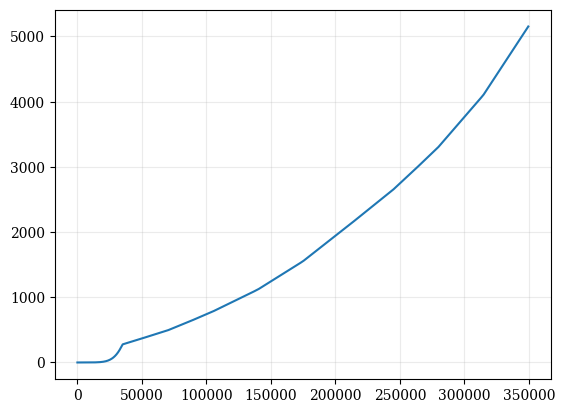

In [95]:
# opt.bail()
print(opt.iterate(1000, 10_000.0))
plt.plot(opt.bake())